# Spark Setup

In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://www-us.apache.org/dist/spark/spark-2.3.4/spark-2.3.4-bin-hadoop2.7.tgz
!tar xf spark-2.3.4-bin-hadoop2.7.tgz
!pip install -q findspark

In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.3.4-bin-hadoop2.7"

import findspark
findspark.init()

from pyspark.sql import SparkSession
spark = SparkSession.builder.master('local[*]').appName('test').getOrCreate()

from pyspark import SparkConf
SparkConf().set("spark.executor.memory", "13g")

In [3]:
import pyspark.sql.functions as F
import pyspark.sql.types as T
from pyspark.ml.feature import Bucketizer 

import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")
import matplotlib
import pandas as pd
import numpy as np
import zipfile
from google.colab import files


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
# Run this cell and select the kaggle.json file downloaded from the Kaggle account settings page.
files.upload()
# Install the Kaggle API client/.
!pip install -q kaggle
# The Kaggle API client expects this file to be in ~/.kaggle so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# Avoid Warnings
!chmod 600 ~/.kaggle/kaggle.json
#  Copy API command from kaggle and paste it to download desired dataset
!kaggle datasets download -d ntnu-testimon/paysim1
# open and extract files 
zip_ref = zipfile.ZipFile('paysim1.zip', 'r')
zip_ref.extractall('files')
zip_ref.close()
# list the files present in zip
!ls files

Saving kaggle.json to kaggle.json
 96% 170M/178M [00:02<00:00, 103MB/s] 
100% 178M/178M [00:02<00:00, 89.3MB/s]
PS_20174392719_1491204439457_log.csv


In [6]:
# Read data to spark dataframe
# set inferSchema = True, to get the input schema automatically from data.
df = spark.read.csv('/content/files/PS_20174392719_1491204439457_log.csv', header=True, inferSchema = True)
# columnar storage of data for efficient complex data processing.
# df.repartition(1).write.partitionBy('type').mode("overwrite").parquet("data/df.parquet")
# df = spark.read.option("mergeSchema", "true").parquet("data/df.parquet")

# EDA

In [ ]:
spark.conf.set("spark.sql.execution.arrow.enabled", "true")

## Fraudulent Trasactions

In [ ]:
total_records = df.count()
type_pc_df = df.groupBy('type').count().withColumn('Percent_Type',F.round(F.col('count')/total_records*100,2))
type_pc_fraud_df = df.select('type','isFraud').groupby('type', 'isFraud').count().withColumn('Percent_Type_Fraud',F.round(F.col('count')/total_records*100,2))
type_pc_flagged_fraud_df = df.select('type','isFlaggedFraud').groupby('type', 'isFlaggedFraud').count().withColumn('Percent_Type_Flagged_Fraud',F.round(F.col('count')/total_records*100,4))
transfer_count = df.filter(F.col('type')=='TRANSFER').count()
cashout_count = df.filter(F.col('type')=='CASH_OUT').count()
fraud_pc_type_only = df.filter((F.col('type')=='TRANSFER')|(F.col('type')=='CASH_OUT')).select('type','isFraud').groupBy('type','isFraud').count().withColumn('Percent_Type_Fraud_Only',F.when(F.col('type')=='TRANSFER',F.col('count')/transfer_count*100).otherwise(F.col('count')/cashout_count*100))



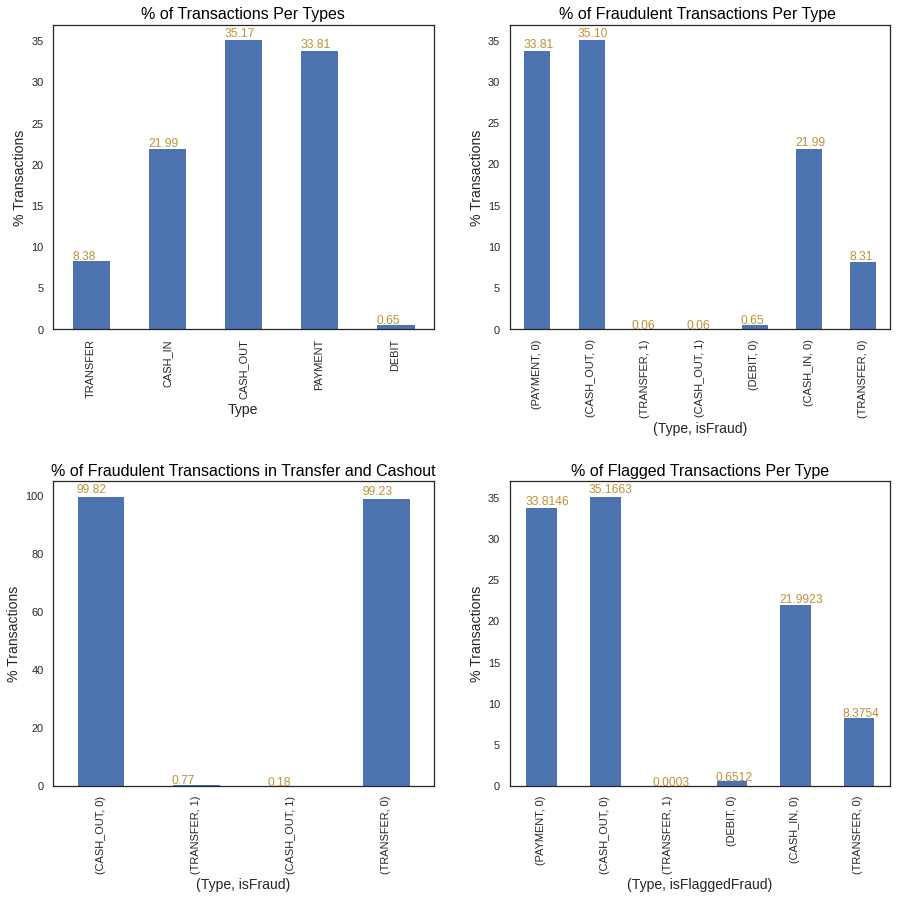

In [ ]:
sns.set()
plt.style.use('seaborn-ticks')
# matplotlib.rcParams.update({'font.size': 13})
# COLOR = '#FEBE28'
COLOR ='#bd9133'
matplotlib.rcParams['text.color'] = COLOR
matplotlib.rcParams['axes.titlecolor'] = 'black'

fig, axes = plt.subplots(2,2,figsize=(15,14))
plt.subplots_adjust(wspace=0.2,hspace =0.5)

type_pc_df.toPandas().plot('type','Percent_Type',kind='bar',ax=axes[0,0])
axes[0,0].get_legend().remove()
axes[0,0].set_title("% of Transactions Per Types",fontsize=16  )
axes[0,0].set_xlabel("Type",fontsize=14)
axes[0,0].set_ylabel("% Transactions",fontsize=14)
for p in axes[0,0].patches:
    axes[0,0].annotate(str(format((p.get_height()), ',.2f')), (p.get_x(), p.get_height()*1.01))


type_pc_fraud_df.toPandas().set_index(['type','isFraud']).drop('count',axis=1).plot(kind='bar',ax=axes[0,1])
axes[0,1].get_legend().remove()
axes[0,1].set_title("% of Fraudulent Transactions Per Type ",fontsize=16  )
axes[0,1].set_xlabel("(Type, isFraud)",fontsize=14)
axes[0,1].set_ylabel("% Transactions",fontsize=14)
for p in axes[0,1].patches:
    axes[0,1].annotate(str(format((p.get_height()), ',.2f')), (p.get_x(), p.get_height()*1.01))


fraud_pc_type_only.toPandas().set_index(['type','isFraud']).drop('count',axis=1).plot(kind='bar',ax=axes[1,0])
axes[1,0].get_legend().remove()
axes[1,0].set_title("% of Fraudulent Transactions in Transfer and Cashout",fontsize=16  )
axes[1,0].set_xlabel("(Type, isFraud)",fontsize=14)
axes[1,0].set_ylabel("% Transactions",fontsize=14)
for p in axes[1,0].patches:
    axes[1,0].annotate(str(format((p.get_height()), ',.2f')), (p.get_x(), p.get_height()*1.01))


type_pc_flagged_fraud_df.toPandas().set_index(['type','isFlaggedFraud']).drop('count',axis=1).plot(kind='bar',ax=axes[1,1])
axes[1,1].get_legend().remove()
axes[1,1].set_title("% of Flagged Transactions Per Type",fontsize=16  )
axes[1,1].set_xlabel("(Type, isFlaggedFraud)",fontsize=14)
axes[1,1].set_ylabel("% Transactions",fontsize=14)
for p in axes[1,1].patches:
    axes[1,1].annotate(str(format((p.get_height()), ',.4f')), (p.get_x(), p.get_height()*1.01))





## Time Step Features

In [7]:
df = df.withColumn('day_of_month', F.when( (F.col('step')%24) !=0, ( ( F.col('step')/24) +1)).otherwise(( F.col('step')/24)).cast(T.IntegerType()))
df = df.withColumn('hour_of_day',F.when((F.col('step')%24)!=0,  (F.col('step')%24)).otherwise(24).cast(T.IntegerType()))
df = df.withColumn('day_of_week',F.when((F.col('day_of_month')%7)!=0,(F.col('day_of_month')%7)).otherwise(7.0))
df = df.withColumn('week_of_month',F.when( (F.col('day_of_month')%7) !=0, ( ( F.col('day_of_month')/7) +1)).otherwise( F.col('day_of_month')/7).cast(T.IntegerType()))

### Day of Week Percentage

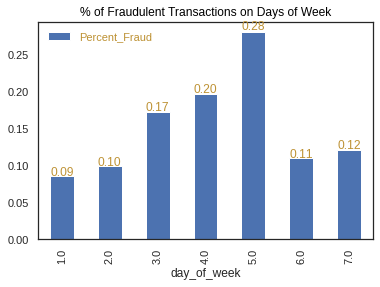

In [ ]:
weekday_fraud=df.filter('isFraud=1').groupby('day_of_week').count().sort('day_of_week').toPandas()
weekday_fraud=weekday_fraud.rename(columns={'count':'fraud_count'})
weekday_fraud['total_count']= df.groupby('day_of_week').count().sort('day_of_week').toPandas()['count']
weekday_fraud['Percent_Fraud'] = weekday_fraud['fraud_count']/weekday_fraud['total_count']*100

ax = weekday_fraud.plot('day_of_week','Percent_Fraud',kind='bar')
ax.set_title("% of Fraudulent Transactions on Days of Week")
for p in ax.patches:
    ax.annotate(str(format((p.get_height()), ',.2f')), (p.get_x(), p.get_height()*1.01))
plt.show()


### Day of Week & Week of Month 

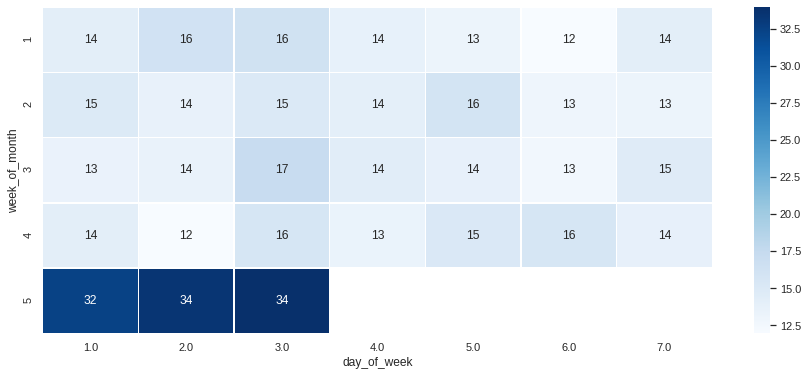

In [ ]:
week_day_fraud_df = df.filter('isFraud=1').groupby('week_of_month','day_of_week').count().sort('week_of_month','day_of_week')
week_day_df = df.filter('isFraud=1').groupby('week_of_month','day_of_week').count().sort('week_of_month','day_of_week')
week_df = week_day_df.groupby('week_of_month').agg({'count':'sum'})
daily_pc_week_df = week_day_fraud_df.join(week_df, on='week_of_month',how='left')
daily_pc_week_df = daily_pc_week_df.withColumn('Daily_Pc_Week_Fraud',F.round(F.col('count')/F.col('sum(count)')*100,2))

daily_frauds_per_week = daily_pc_week_df.toPandas().pivot("week_of_month", "day_of_week", "Daily_Pc_Week_Fraud")
f, ax = plt.subplots(figsize=(15, 6))
sns.heatmap(daily_frauds_per_week, annot=True,  linewidths=.5, ax=ax, cmap='Blues')
plt.show()

### 24/7 Heathmap

#### Count

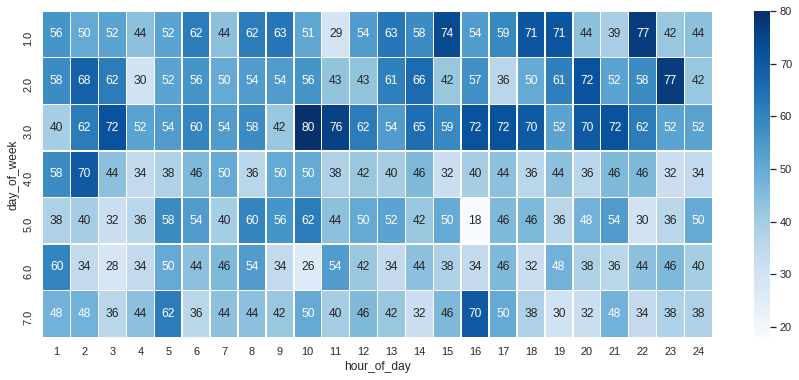

In [ ]:
hour_week_fraud = df.filter('isFraud=1').groupby('day_of_week','hour_of_day').count().sort('day_of_week','hour_of_day').toPandas()
hour_week_fraud=hour_week_fraud.rename(columns={'count':'fraud_count'})

fraud_hours_of_day = hour_week_fraud.pivot("day_of_week", "hour_of_day", "fraud_count")
f, ax = plt.subplots(figsize=(15, 6))
sns.heatmap(fraud_hours_of_day, annot=True,  linewidths=.5, ax=ax, cmap='Blues')
plt.show()

#### Percentage

In [ ]:
hour_week_fraud_percent = hour_week_fraud.groupby(['day_of_week', 'hour_of_day']).agg({'fraud_count': 'sum'})
hour_week_fraud_percent = hour_week_fraud_percent.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))
hour_week_fraud_percent=hour_week_fraud_percent.rename(columns={'fraud_count':'fraud_percentage'})
hour_week_fraud_percent.reset_index(inplace = True)
hour_week_fraud_percent['fraud_count'] = hour_week_fraud['fraud_count']

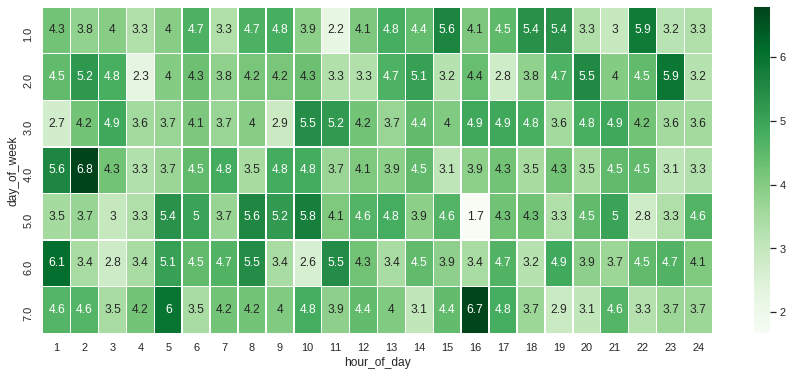

In [ ]:
fraud_hours_of_day = hour_week_fraud_percent.pivot("day_of_week", "hour_of_day", "fraud_percentage")
f, ax = plt.subplots(figsize=(15, 6))
sns.heatmap(fraud_hours_of_day, annot=True,  linewidths=.5, ax=ax, cmap='Greens')
plt.show()

## Balance & Amount Analysis


In [8]:
df_final = df.filter(F.col('type').isin(['TRANSFER','CASH_OUT']))
fraud_df = df_final.filter(F.col('isFraud')==1)
genuine_df = df_final.filter(F.col('isFraud')==0)

In [ ]:
arrays = [['Old','New','Both','Old','New','Both'],['0','0','0','>0','>0','>0']]
tuples= list(zip(*arrays))
index = pd.MultiIndex.from_tuples(tuples, names=['Balance Source', 'Amount Value'])
bal_df = pd.DataFrame(index=index,columns=['Originating','Destination','Both'])
arrays = [['Zero','Non-zero'],['Old','New','Both']]
index = pd.MultiIndex.from_product(arrays, names=['Amount Value','Balance Source'])
bal_df = pd.DataFrame(index=index,columns=['Originating','Destination','Both'])

bal_df.loc[('Zero','Old')]['Originating'] = df_fraud.filter('oldbalanceOrg = 0 AND amount=0' ).count()
bal_df.loc[('Zero','Old')]['Destination'] = df_fraud.filter('oldbalanceDest = 0 AND amount=0' ).count()
bal_df.loc[('Zero','Old')]['Both'] = df_fraud.filter('oldbalanceOrg = 0 AND oldbalanceDest = 0 AND amount=0' ).count()
bal_df.loc[('Zero','New')]['Originating'] = df_fraud.filter('newbalanceOrig = 0 AND amount=0' ).count()
bal_df.loc[('Zero','New')]['Destination'] = df_fraud.filter('newbalanceDest = 0 AND amount=0' ).count()
bal_df.loc[('Zero','New')]['Both'] = df_fraud.filter('newbalanceOrig = 0 AND newbalanceDest = 0 AND amount=0' ).count()
bal_df.loc[('Zero','Both')]['Originating'] = df_fraud.filter('oldbalanceOrg = 0 AND newbalanceOrig = 0 AND amount=0' ).count()
bal_df.loc[('Zero','Both')]['Destination'] = df_fraud.filter('oldbalanceDest = 0 AND newbalanceDest = 0 AND amount=0' ).count()
bal_df.loc[('Zero','Both')]['Both'] = df_fraud.filter('oldbalanceOrg = 0 AND newbalanceOrig = 0  AND oldbalanceDest = 0 AND newbalanceDest = 0 AND amount=0' ).count()


bal_df.loc[('Non-zero','Old')]['Originating'] = df_fraud.filter('oldbalanceOrg = 0 AND amount>0' ).count()
bal_df.loc[('Non-zero','Old')]['Destination'] = df_fraud.filter('oldbalanceDest = 0 AND amount>0' ).count()
bal_df.loc[('Non-zero','Old')]['Both'] = df_fraud.filter('oldbalanceOrg = 0 AND oldbalanceDest = 0 AND amount>0' ).count()
bal_df.loc[('Non-zero','New')]['Originating'] = df_fraud.filter('newbalanceOrig = 0 AND amount>0' ).count()
bal_df.loc[('Non-zero','New')]['Destination'] = df_fraud.filter('newbalanceDest = 0 AND amount>0' ).count()
bal_df.loc[('Non-zero','New')]['Both'] = df_fraud.filter('newbalanceOrig = 0 AND newbalanceDest = 0 AND amount>0' ).count()
bal_df.loc[('Non-zero','Both')]['Originating'] = df_fraud.filter('oldbalanceOrg = 0 AND newbalanceOrig = 0 AND amount>0' ).count()
bal_df.loc[('Non-zero','Both')]['Destination'] = df_fraud.filter('oldbalanceDest = 0 AND newbalanceDest = 0 AND amount>0' ).count()
bal_df.loc[('Non-zero','Both')]['Both'] = df_fraud.filter('oldbalanceOrg = 0 AND newbalanceOrig = 0  AND oldbalanceDest = 0 AND newbalanceDest = 0 AND amount>0' ).count()

bal_df

Originating Destination  Both
Amount Value Balance Source                              
Zero         Old                     16           6     6
             New                     16           6     6
             Both                    16           6     6
Non-zero     Old                     25        5345    10
             New                   8037        4085  3927
             Both                    25        4070     0

# Data Cleaning

Insert -1 in oldbalanceDest and newbalanceDest where old and new destination balance is zero and transaction amount is greater than zero. 

In [ ]:
# df_final = df_final.withColumn('oldbalanceDest', F.when((F.col('oldbalanceDest')==0) & (F.col('newbalanceDest')==0) & (F.col('amount')!=0),-1).otherwise(F.col('oldbalanceDest')) )
# df_final = df_final.withColumn('newbalanceDest', F.when((F.col('oldbalanceDest')==-1),-1).otherwise(F.col('newbalanceDest')) )


This happnes mostly in the genuine transactions that originating balance is zero, it's not useful for detecting fraud. So model should consider it a Null value and not learn anything from this, that is when this happens consider the trancation as genuine. For indicating this we replace it with NaN.

In [ ]:
# df_final = df_final.withColumn('oldbalanceOrg', F.when((F.col('oldbalanceOrg')==0) & (F.col('newbalanceOrig')==0) & (F.col('amount')!=0),np.nan).otherwise(F.col('oldbalanceOrg')) )
# df_final = df_final.withColumn('newbalanceOrig', F.when((F.col('oldbalanceOrg')==np.nan),np.nan).otherwise(F.col('newbalanceOrig')) )


In [9]:
df_final = df_final.withColumn('TRANSFER',F.when(F.col('type')=='TRANSFER',1).otherwise(0))
df_final = df_final.withColumn('CASH_OUT',F.when(F.col('type')=='CASH_OUT',1).otherwise(0))


# Feature Engineering 

Excluded error balance features, they were included in the previous notebook.

Split Amount in 93 Buckets, each of one million.

In [12]:
bucketizer = Bucketizer(splits=list(range(0,100000000,1000000)),inputCol='amount', outputCol= "amount_bucket")
df_final = bucketizer.transform(df_final)
df_final = df_final.withColumn('amount_bucket',F.col('amount_bucket')+1)

In [17]:
df_final.columns

['step',
 'amount',
 'oldbalanceOrg',
 'newbalanceOrig',
 'oldbalanceDest',
 'newbalanceDest',
 'isFraud',
 'hour_of_day',
 'TRANSFER',
 'CASH_OUT',
 'amount_bucket']

In [11]:
df_final = df_final.drop(*['nameOrig', 'nameDest','isFlaggedFraud','type','day_of_month', 'day_of_week', 'week_of_month'])

In [18]:
df_final = df_final.sort('step')

In [19]:
df_final.show()

+----+---------+-------------+--------------+--------------+--------------+-------+-----------+--------+--------+-------------+
|step|   amount|oldbalanceOrg|newbalanceOrig|oldbalanceDest|newbalanceDest|isFraud|hour_of_day|TRANSFER|CASH_OUT|amount_bucket|
+----+---------+-------------+--------------+--------------+--------------+-------+-----------+--------+--------+-------------+
|   1|125872.53|          0.0|           0.0|      348512.0|    3420103.09|      0|          1|       1|       0|          1.0|
|   1| 47458.86|    209534.84|     162075.98|       52120.0|           0.0|      0|          1|       0|       1|          1.0|
|   1|224606.64|          0.0|           0.0|     354678.92|           0.0|      0|          1|       1|       0|          1.0|
|   1|  56953.9|      1942.02|           0.0|       70253.0|      64106.18|      0|          1|       0|       1|          1.0|
|   1| 82940.31|      3017.87|           0.0|      132372.0|      49864.36|      0|          1|       0|

In [20]:
X = df_final.drop('isFraud')
Y = df_final.select('isFraud')

# Modeling

In [43]:
# Importing Libraries
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, average_precision_score, confusion_matrix,f1_score, precision_recall_curve
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

In [126]:
def presult(clf,x_test,y_test):
    y_prob=clf.predict_proba(x_test)
    y_pred=clf.predict(x_test)

    print  ('Confusion_matrix : ')
    if type(clf).__name__ == 'Sequential':
      cf_matrix =  confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
      print("Precision:",precision_score(y_test.argmax(axis=1),y_pred.argmax(axis=1)))
      print("Recall:", recall_score(y_test.argmax(axis=1),y_pred.argmax(axis=1)))
    else:
      cf_matrix= confusion_matrix(y_test,y_pred)
      print("Precision:",precision_score(y_test,y_pred))
      print("Recall:", recall_score(y_test,y_pred))

    print (cf_matrix)
    # sns.heatmap(confusion_matrix(testY,y_pred), annot=True,annot_kws={"size": 15},fmt='10g')
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_names,group_counts)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
    plt.show()


In [56]:
def plot_importance(model):
  if type(model).__name__ == 'LogisticRegression':
    importance = model.coef_[0]
  else:
    importance = model.feature_importances_
  # summarize feature importance
  data = dict(zip(Xpd.columns, importance))
  model = pd.DataFrame.from_dict(data.items())
  model.rename(columns={0:'columns', 1:'importance'},inplace = True)
  ax = model.plot(x = 'columns',kind='bar')
  ax.set_title("feature importance")
  for p in ax.patches:
    ax.annotate(str(format((p.get_height()), ',.2f')), (p.get_x(), p.get_height()*1.01))
  plt.show()

In [68]:
# Conversion to Pandas DataFrame
Xpd=X.toPandas()
Ypd=Y.toPandas()

### Split in Train, Test & Validation

In [69]:
# Splitting data
trainX, testX, trainY, testY = train_test_split(Xpd, Ypd, test_size = 0.2, random_state = 123)

## Decision Tree 

In [70]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
dtree_clf =   DecisionTreeClassifier(random_state=0, class_weight='balanced')

In [71]:
trainX_filled = trainX.fillna(0)
testX_filled = testX.fillna(0)

In [72]:
dtree_clf.fit(trainX_filled, trainY)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

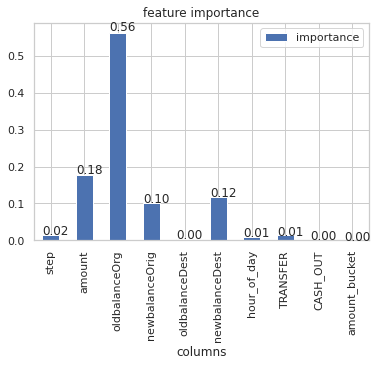

In [73]:
plot_importance(dtree_clf)

Confusion_matrix : 
Precision: 0.9042485732403297
Recall: 0.8442865600947306
[[552242    151]
 [   263   1426]]


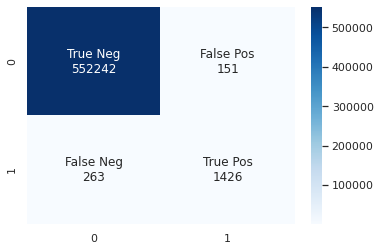

In [76]:
presult(dtree_clf,testX_filled,testY)

## XGBoost

### Model with Parameters 
###Model 1
**scale_pos_weight**: Control the balance of positive and negative weights, useful for unbalanced classes. 

**ratio**: count(negative instances) / count(positive instances)




In [77]:
ratio = int(df_final.filter('isFraud=0').count()/df_final.filter('isFraud=1').count())
ratio

336

In [78]:
xg_cl_tuned_1 = xgb.XGBClassifier(scale_pos_weight = ratio, n_estimators=100)

In [79]:
trainX_val, valX_val, trainY_val, valY_val = train_test_split(trainX, trainY, test_size=0.2, random_state=123)

In [80]:
eval_set = [(valX_val, valY_val.values.ravel())]
xg_cl_tuned_1.fit(trainX_val, trainY_val.values.ravel(),eval_metric="error", early_stopping_rounds=12,eval_set=eval_set, verbose=True)

[0]	validation_0-error:0.105133
Will train until validation_0-error hasn't improved in 12 rounds.
[1]	validation_0-error:0.105903
[2]	validation_0-error:0.105395
[3]	validation_0-error:0.105833
[4]	validation_0-error:0.103538
[5]	validation_0-error:0.102629
[6]	validation_0-error:0.101314
[7]	validation_0-error:0.09744
[8]	validation_0-error:0.099141
[9]	validation_0-error:0.057379
[10]	validation_0-error:0.055827
[11]	validation_0-error:0.05307
[12]	validation_0-error:0.051452
[13]	validation_0-error:0.051436
[14]	validation_0-error:0.051344
[15]	validation_0-error:0.050863
[16]	validation_0-error:0.049771
[17]	validation_0-error:0.04937
[18]	validation_0-error:0.044774
[19]	validation_0-error:0.044935
[20]	validation_0-error:0.047525
[21]	validation_0-error:0.044689
[22]	validation_0-error:0.040012
[23]	validation_0-error:0.0386
[24]	validation_0-error:0.039175
[25]	validation_0-error:0.039141
[26]	validation_0-error:0.031266
[27]	validation_0-error:0.027514
[28]	validation_0-error:0

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=336, seed=None,
              silent=None, subsample=1, verbosity=1)

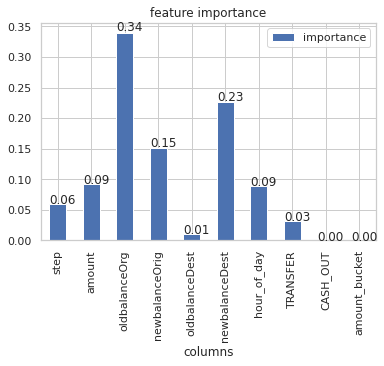

In [81]:
plot_importance(xg_cl_tuned_1)

Confusion_matrix : 
Precision: 0.14249761346871476
Recall: 0.9721728833629366
[[542512   9881]
 [    47   1642]]


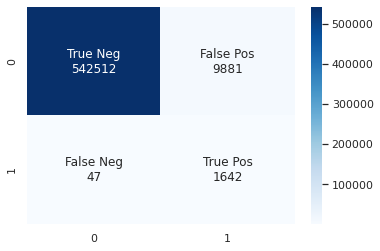

In [82]:
 presult(xg_cl_tuned_1,testX,testY)

##  Model 2

**scale_pos_weight**:  square root of ratio
Ratio that we used above gives high weight to rare class and thus produces very low precision but that's not a good model as it may mark many negative cases to be positive.
Hence we use the square root of the same ratio.

https://stats.stackexchange.com/questions/243207/what-is-the-proper-usage-of-scale-pos-weight-in-xgboost-for-imbalanced-datasets



In [83]:
xg_cl_tuned_2 = xgb.XGBClassifier(scale_pos_weight = np.sqrt(ratio), n_estimators=100)

In [84]:
eval_set = [(valX_val, valY_val.values.ravel())]
xg_cl_tuned_2.fit(trainX_val, trainY_val.values.ravel(),eval_metric="error", early_stopping_rounds=12,eval_set=eval_set, verbose=True)

[0]	validation_0-error:0.004629
Will train until validation_0-error hasn't improved in 12 rounds.
[1]	validation_0-error:0.004629
[2]	validation_0-error:0.004629
[3]	validation_0-error:0.004629
[4]	validation_0-error:0.004652
[5]	validation_0-error:0.004652
[6]	validation_0-error:0.004652
[7]	validation_0-error:0.004643
[8]	validation_0-error:0.001311
[9]	validation_0-error:0.001311
[10]	validation_0-error:0.001311
[11]	validation_0-error:0.001297
[12]	validation_0-error:0.001297
[13]	validation_0-error:0.001297
[14]	validation_0-error:0.001288
[15]	validation_0-error:0.001293
[16]	validation_0-error:0.001299
[17]	validation_0-error:0.001279
[18]	validation_0-error:0.001293
[19]	validation_0-error:0.001266
[20]	validation_0-error:0.001259
[21]	validation_0-error:0.001367
[22]	validation_0-error:0.001365
[23]	validation_0-error:0.001358
[24]	validation_0-error:0.001345
[25]	validation_0-error:0.001345
[26]	validation_0-error:0.001354
[27]	validation_0-error:0.00136
[28]	validation_0-err

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=18.33030277982336,
              seed=None, silent=None, subsample=1, verbosity=1)

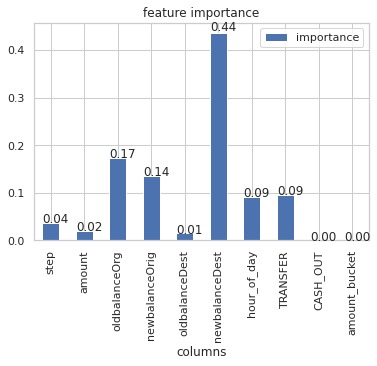

In [85]:
plot_importance(xg_cl_tuned_2)

Confusion_matrix : 
Precision: 0.7956337174044875
Recall: 0.7767910005920663
[[552056    337]
 [   377   1312]]


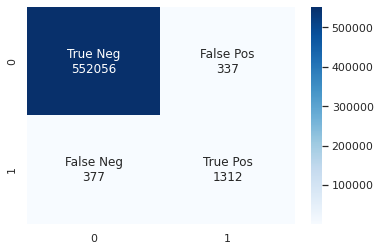

In [86]:
presult(xg_cl_tuned_2,testX,testY)

## Model 3
**Default parameters**

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [87]:
xg_cl_default = xgb.XGBClassifier()
xg_cl_default.fit(trainX, trainY.values.ravel())

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

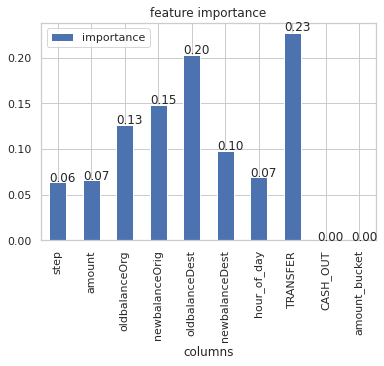

In [88]:
plot_importance(xg_cl_default)

Confusion_matrix : 
Precision: 0.9878511769172361
Recall: 0.7702782711663706
[[552377     16]
 [   388   1301]]


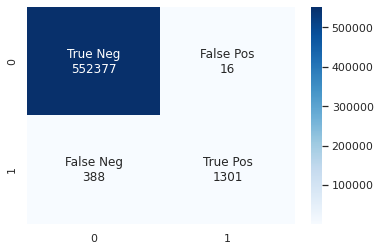

In [89]:
presult(xg_cl_default,testX,testY)

## Undersampling for Logistic Regression and Neural Network

In [105]:
# Separate majority and minority classes
df_majority = df_final.filter('isFraud=0')
df_minority = df_final.filter('isFraud=1')

In [106]:
sampled_majority_df = df_majority.sample(False, 1/ratio)
combined_df_2 = sampled_majority_df.unionAll(df_minority)
combined_df_2 = combined_df_2.toPandas()

In [107]:
Xpd = combined_df_2.drop('isFraud',axis=1)
Ypd = combined_df_2[['isFraud']]

## Logistic Regression

In [93]:
# Splitting data
trainX, testX, trainY, testY = train_test_split(Xpd, Ypd, test_size = 0.2, random_state = 123)

In [94]:
from sklearn.linear_model import LogisticRegression

lr_cl = LogisticRegression(random_state=123)
lr_cl.fit(trainX, trainY)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=123, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [95]:
 
# Predict on training set
lr_preds = lr_cl.predict(testX)


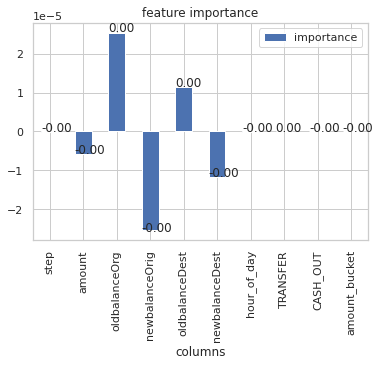

In [96]:
plot_importance(lr_cl)

Logistic Regression
Confusion_matrix : 
Precision: 0.8971692663200462
Recall: 0.9694132334581773
[[1541  178]
 [  49 1553]]


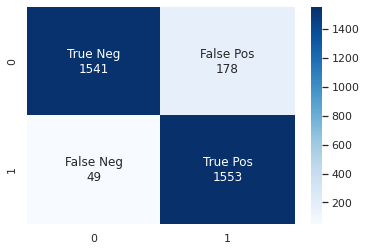

In [97]:
print('Logistic Regression')
presult(lr_cl,testX,testY)

## Neural Network

In [112]:
Ypd=Ypd.values.reshape(-1,1)
st_sc = StandardScaler()
Xpd = st_sc.fit_transform(Xpd)

In [116]:
ohe=OneHotEncoder()
Ypd=ohe.fit_transform(Ypd).toarray()

In [118]:
x_train, x_test, y_train,y_test=train_test_split(Xpd,Ypd, test_size=0.2, random_state=1)

In [119]:
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.models import load_model
model = Sequential()
model.add(Dense(units = 64, input_dim = 10, activation = "relu"))
model.add(Dense(units = 32, activation = "relu"))
model.add(Dropout(0.3))
model.add(Dense(units = 2, activation = "sigmoid"))
model.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 64)                704       
_________________________________________________________________
dense_11 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 2)                 66        
Total params: 2,850
Trainable params: 2,850
Non-trainable params: 0
_________________________________________________________________


In [128]:
model.fit(x_train, y_train, epochs = 10, verbose=1)

Epoch 1/10
13260/13260 [==============================] - 1s 44us/step - loss: 0.1642 - accuracy: 0.9406
Epoch 2/10
13260/13260 [==============================] - 1s 44us/step - loss: 0.1460 - accuracy: 0.9475
Epoch 3/10
13260/13260 [==============================] - 1s 43us/step - loss: 0.1365 - accuracy: 0.9507
Epoch 4/10
13260/13260 [==============================] - 1s 44us/step - loss: 0.1330 - accuracy: 0.9498
Epoch 5/10
13260/13260 [==============================] - 1s 42us/step - loss: 0.1221 - accuracy: 0.9546
Epoch 6/10
13260/13260 [==============================] - 1s 45us/step - loss: 0.1248 - accuracy: 0.9560
Epoch 7/10
13260/13260 [==============================] - 1s 43us/step - loss: 0.1148 - accuracy: 0.9573
Epoch 8/10
13260/13260 [==============================] - 1s 43us/step - loss: 0.1104 - accuracy: 0.9611
Epoch 9/10
13260/13260 [==============================] - 1s 42us/step - loss: 0.1158 - accuracy: 0.9575
Epoch 10/10
13260/13260 [==============================

Confusion_matrix : 
Precision: 0.9617021276595744
Recall: 0.9593693147362038
[[1603   63]
 [  67 1582]]


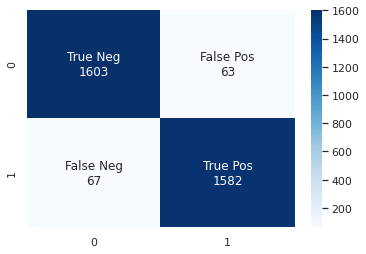

In [129]:
presult(model,x_test,y_test)